In [47]:
import dlc_bci as bci
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

#pgdc de 316 et 100 c'est 4
mini_batch_size = 4

train_input, train_target  = bci.load(root = './data_bci')

print(str(type(train_input)),train_input.size())
print(str(type(train_target)),train_target.size())


test_input, test_target  = bci.load(root = './data_bci', train=False)

print(str(type(test_input)),test_input.size())
print(str(type(test_target)),test_target.size())

train_input = train_input.view(len(train_input),1,train_input.size(1),-1)
test_input = test_input.view(len(test_input),1,test_input.size(1),-1)

train_input, test_input, train_target, test_target = Variable(train_input), Variable(test_input), Variable(train_target), Variable(test_target)

# data already 1400 dimensions, implement a Convolution layer

class first_model(nn.Module):
    def __init__(self,nb_hidden):
        super(first_model, self).__init__()
        self.conv1 = nn.Conv2d(1,3, kernel_size = 7) #3x22x44
        self.fc1 = nn.Linear(363, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = (2,4))) # 3x11x11
        x = F.relu(self.fc1(x.view(mini_batch_size,-1)))
        x = self.fc2(x)
        return x

def train_model(model, train_input, train_target,mini_batch_size):
    
    criterion = nn.CrossEntropyLoss()
    eta = 1e-1
    optimizer = torch.optim.SGD(model.parameters(),lr=eta)
    nb_epochs = 100

    for e in range(0, nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()

def compute_nb_errors(model, data_input, data_target, mini_batch_size):
    
    nb_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        print(output)
        _, predicted_classes = output.data.max(1)
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] - predicted_classes[k] != 0:
                nb_errors = nb_errors + 1
    return int(nb_errors)



for nh in [ 10, 50, 200, 500, 2500 ]:
    model = first_model(nh)
    train_model(model, train_input, train_target, mini_batch_size)
    nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)
    print('test error first model nh={:d} {:0.2f}%% {:d}/{:d}'.format(nh,
                                                              (100 * nb_test_errors) / test_input.size(0),
                                                              nb_test_errors, test_input.size(0)))

In [8]:
nb_errors = 0

for b in range(0, train_input.size(0), mini_batch_size):
    output = model.forward(train_input.narrow(0, b, mini_batch_size))
    _, predicted_classes = output.data.max(1)
    for k in range(0, mini_batch_size):
        if train_target.data[b + k] - predicted_classes[k] != 0:
            nb_errors = nb_errors + 1

In [20]:
ok = nn.Conv2d(1,3, kernel_size = 7)
ok2 = nn.Linear(363, 100)
ok3 = nn.Linear(100, 2)

x = F.relu(F.max_pool2d(ok(train_input.narrow(0, 0, 4)), kernel_size = (2,4)))

In [22]:
np.shape(x)

torch.Size([4, 3, 11, 11])

In [23]:
x = F.relu(ok2(x.view(4,-1)))

In [25]:
np.shape(x)

torch.Size([4, 100])

In [43]:
x = F.relu(ok3(x))

In [44]:
x

Variable containing:
 2.8802  0.0000
 0.4807  0.0000
 2.0839  0.0000
 0.0000  0.0000
[torch.FloatTensor of size 4x2]

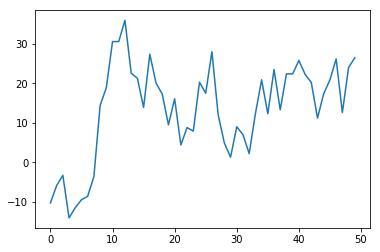

In [42]:
plt.plot(train_input[0][0][1,:].data.numpy())

In [45]:
output = model.forward(train_input.narrow(0, 0, 4))

In [46]:
output

Variable containing:
nan nan
nan nan
nan nan
nan nan
[torch.FloatTensor of size 4x2]